# Eval code

In [73]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
from collections import defaultdict

def load_df(event_path, filter_prefix=None):
    # Load the TensorBoard event file
    event_acc = EventAccumulator(event_path)
    event_acc.Reload()

    # Get list of available tags/metrics
    tags = event_acc.Tags()

    # Create dictionary to store metrics
    metrics = {}

    # Extract metrics into dictionary
    for tag in tags['scalars']:
        if filter_prefix and not tag.startswith(filter_prefix):
            continue
        events = event_acc.Scalars(tag)
        metrics[tag] = pd.DataFrame(events)[['step', 'value']]
        metrics[tag] = metrics[tag].set_index('step')
        metrics[tag].columns = [tag]

    # Combine all metrics into single dataframe by joining on step index
    df = pd.DataFrame()
    for metric_df in metrics.values():
        df = df.join(metric_df, how='outer')

    return df

In [81]:
# Find all tensorboard files in slurm/ALE directory
tensorboard_files = glob.glob(r"slurm/ALE/**/events.out.tfevents.*", recursive=True)

# Group files by experiment name (everything before __1__)
experiments = defaultdict(list)
for file in tensorboard_files:
    # Extract experiment name and date
    path_parts = file.split('\\')
    exp_parts = path_parts[-2].split('__1__')
    if len(exp_parts) != 2:
        continue
    exp_name, date = exp_parts
    experiments[exp_name].append((date, file))

# Keep only the latest file for each experiment
tensorboard_paths = {}
for exp_name, files in experiments.items():
    # Sort by date and take the latest
    latest_file = sorted(files, key=lambda x: x[0])[-1][1]
    # Use the part after last dash as the key
    key = exp_name.split('__')[-1]
    tensorboard_paths[key] = latest_file

tensorboard_paths

{'epsilon_tuning_0.1': 'slurm/ALE\\SpaceInvaders-v5__epsilon_tuning_0.1__1__20241223_000723\\events.out.tfevents.1734908858.server0103.3052486.0',
 'epsilon_tuning_0.2': 'slurm/ALE\\SpaceInvaders-v5__epsilon_tuning_0.2__1__20241223_003839\\events.out.tfevents.1734910725.server0103.3060251.0',
 'epsilon_tuning_0.3': 'slurm/ALE\\SpaceInvaders-v5__epsilon_tuning_0.3__1__20241223_011006\\events.out.tfevents.1734912622.server0103.3067890.0',
 'epsilon_tuning_0.4': 'slurm/ALE\\SpaceInvaders-v5__epsilon_tuning_0.4__1__20241223_014124\\events.out.tfevents.1734914490.server0103.3075611.0',
 'iem_ppo': 'slurm/ALE\\SpaceInvaders-v5__iem_ppo__1__20241223_000744\\events.out.tfevents.1734908873.server0105.3585319.0',
 'initial_run': 'slurm/ALE\\SpaceInvaders-v5__initial_run__1__20241222_223225\\events.out.tfevents.1734903150.server0103.3030611.0',
 'ppo_clean_rl': 'slurm/ALE\\SpaceInvaders-v5__ppo_clean_rl__1__20241222_222830\\events.out.tfevents.1734902927.server0103.3029169.0',
 'ppo_resnet_pretra

In [82]:
baseline_df = load_df(tensorboard_paths['random_baseline'], filter_prefix="eval/")
print(f"baseline_df.shape: {baseline_df.shape}")
baseline_df.head()

baseline_df.shape: (100, 3)


,eval/episodic_return,eval/episodic_length,eval/episodic_time
step,,,
0,140.0,475.0,0.219684
1,125.0,694.0,0.328546
2,155.0,528.0,0.210925
3,160.0,615.0,0.244937
4,55.0,482.0,0.194409


In [83]:
initial_df = load_df(tensorboard_paths['initial_run'], filter_prefix="eval/")
initial_df.head()

,eval/episodic_return,eval/episodic_length,eval/episodic_time
step,,,
0,395.0,912.0,0.815236
1,335.0,677.0,0.438964
2,385.0,763.0,0.464337
3,455.0,867.0,0.524935
4,805.0,1030.0,0.598944


In [76]:
def plot_episode_stats_boxplots(df):
    """
    Create box plots showing the distribution of episode returns, lengths and times.
    
    Args:
        df: DataFrame containing columns 'eval/episodic_return', 'eval/episodic_length', 'eval/episodic_time'
    """
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Calculate statistics for each metric
    returns = df['eval/episodic_return'].dropna()
    lengths = df['eval/episodic_length'].dropna() 
    times = df['eval/episodic_time'].dropna()

    # Create box plots for each metric
    sns.boxplot(y=returns, ax=axes[0])
    axes[0].set_title(f'Episode Returns\nMean: {returns.mean():.1f}, Std: {returns.std():.1f}')
    axes[0].set_ylabel('Return')

    sns.boxplot(y=lengths, ax=axes[1])
    axes[1].set_title(f'Episode Lengths\nMean: {lengths.mean():.1f}, Std: {lengths.std():.1f}')
    axes[1].set_ylabel('Length')

    sns.boxplot(y=times, ax=axes[2])
    axes[2].set_title(f'Episode Times\nMean: {times.mean():.3f}, Std: {times.std():.3f}')
    axes[2].set_ylabel('Time (s)')

    plt.tight_layout()
    plt.show()

In [109]:
def plot_episode_stats_violin(*dfs, labels=None):
    """
    Create violin plots showing the distribution of episode returns, lengths and times,
    with median and 10th/90th percentile lines. Plots multiple dataframes side by side.
    
    Args:
        *dfs: Variable number of DataFrames containing columns 'eval/episodic_return', 
              'eval/episodic_length', 'eval/episodic_time'
        labels: Optional list of labels for each DataFrame
    """
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(dfs))]
        
    # Create figure with stacked subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    
    metrics = ['eval/episodic_return', 'eval/episodic_length', 'eval/episodic_time']
    titles = ['Episode Returns', 'Episode Lengths', 'Episode Times']
    ylabels = ['Return', 'Length', 'Time (s)']
    
    # Define colors for each violin
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
        for j, df in enumerate(dfs):
            data = df[metric].dropna()
            
            # Calculate statistics
            median = np.median(data)
            p10 = np.percentile(data, 10)
            p90 = np.percentile(data, 90)
            
            # Position for this violin
            pos = j + 1
            
            # Create violin plot with clipped ends
            parts = axes[i].violinplot(data, positions=[pos], showmedians=False, showextrema=False)
            
            # Customize violin appearance
            for pc in parts['bodies']:
                pc.set_facecolor(colors[j % len(colors)])
                pc.set_alpha(0.5)
            
            # Add lines for median and percentiles
            if j == 0:
                # Draw full-width lines for first violin plot with transparency
                axes[i].axhline(y=median, color='red', linestyle='-', alpha=0.3, label='Median')
                axes[i].axhline(y=p10, color='blue', linestyle='--', alpha=0.3, label='10th/90th percentile') 
                axes[i].axhline(y=p90, color='blue', linestyle='--', alpha=0.3)
            else:
                # Regular short lines for other violin plots
                axes[i].hlines(median, pos-0.2, pos+0.2, color='red', linestyle='-')
                axes[i].hlines(p10, pos-0.2, pos+0.2, color='blue', linestyle='--')
                axes[i].hlines(p90, pos-0.2, pos+0.2, color='blue', linestyle='--')
            
        # Customize plot
        axes[i].set_xticks(range(1, len(dfs) + 1))
        axes[i].set_xticklabels(labels)
        
        # Add statistics to title
        stats_text = []
        for j, df in enumerate(dfs):
            data = df[metric].dropna()
            median = np.median(data)
            p10 = np.percentile(data, 10)
            p90 = np.percentile(data, 90)
            stats_text.append(f'{labels[j]}: Med={median:.1f}, 10th={p10:.1f}, 90th={p90:.1f}')
        
        axes[i].set_title(f"{title}\n" + "\n".join(stats_text))
        axes[i].set_ylabel(ylabel)
        axes[i].legend()

    plt.tight_layout()
    plt.show()


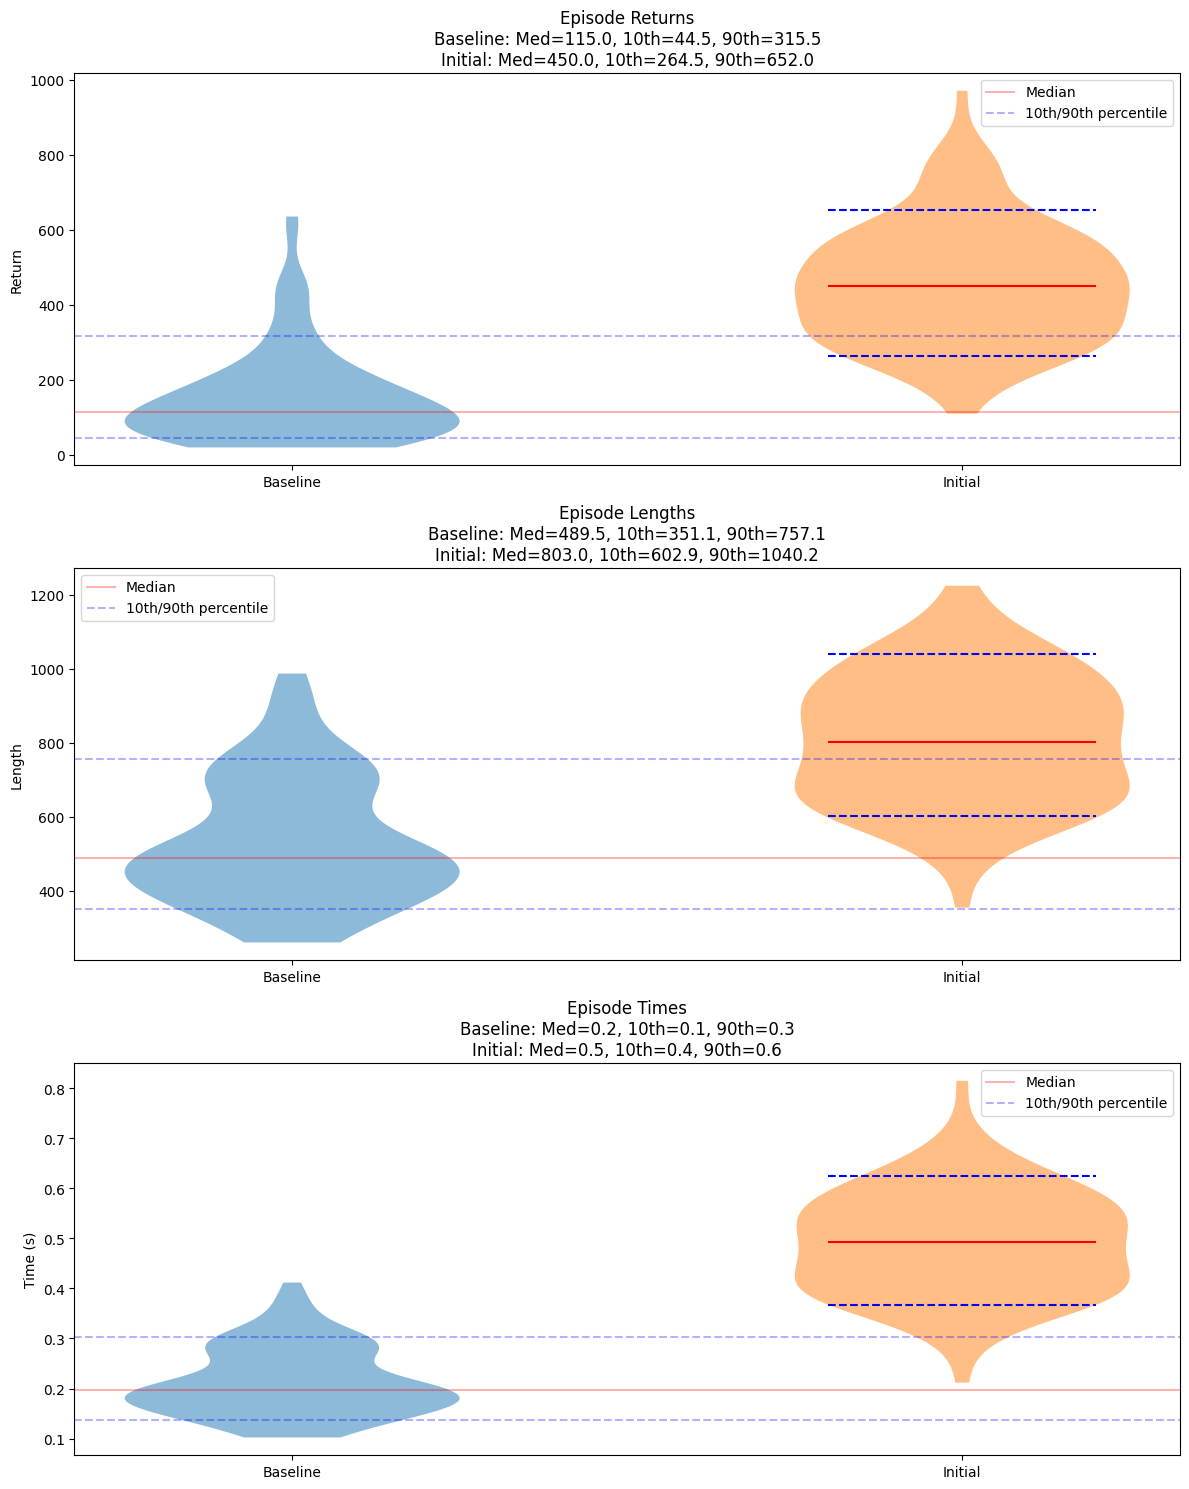

In [110]:
plot_episode_stats_violin(baseline_df, initial_df, labels=['Baseline', 'Initial'])

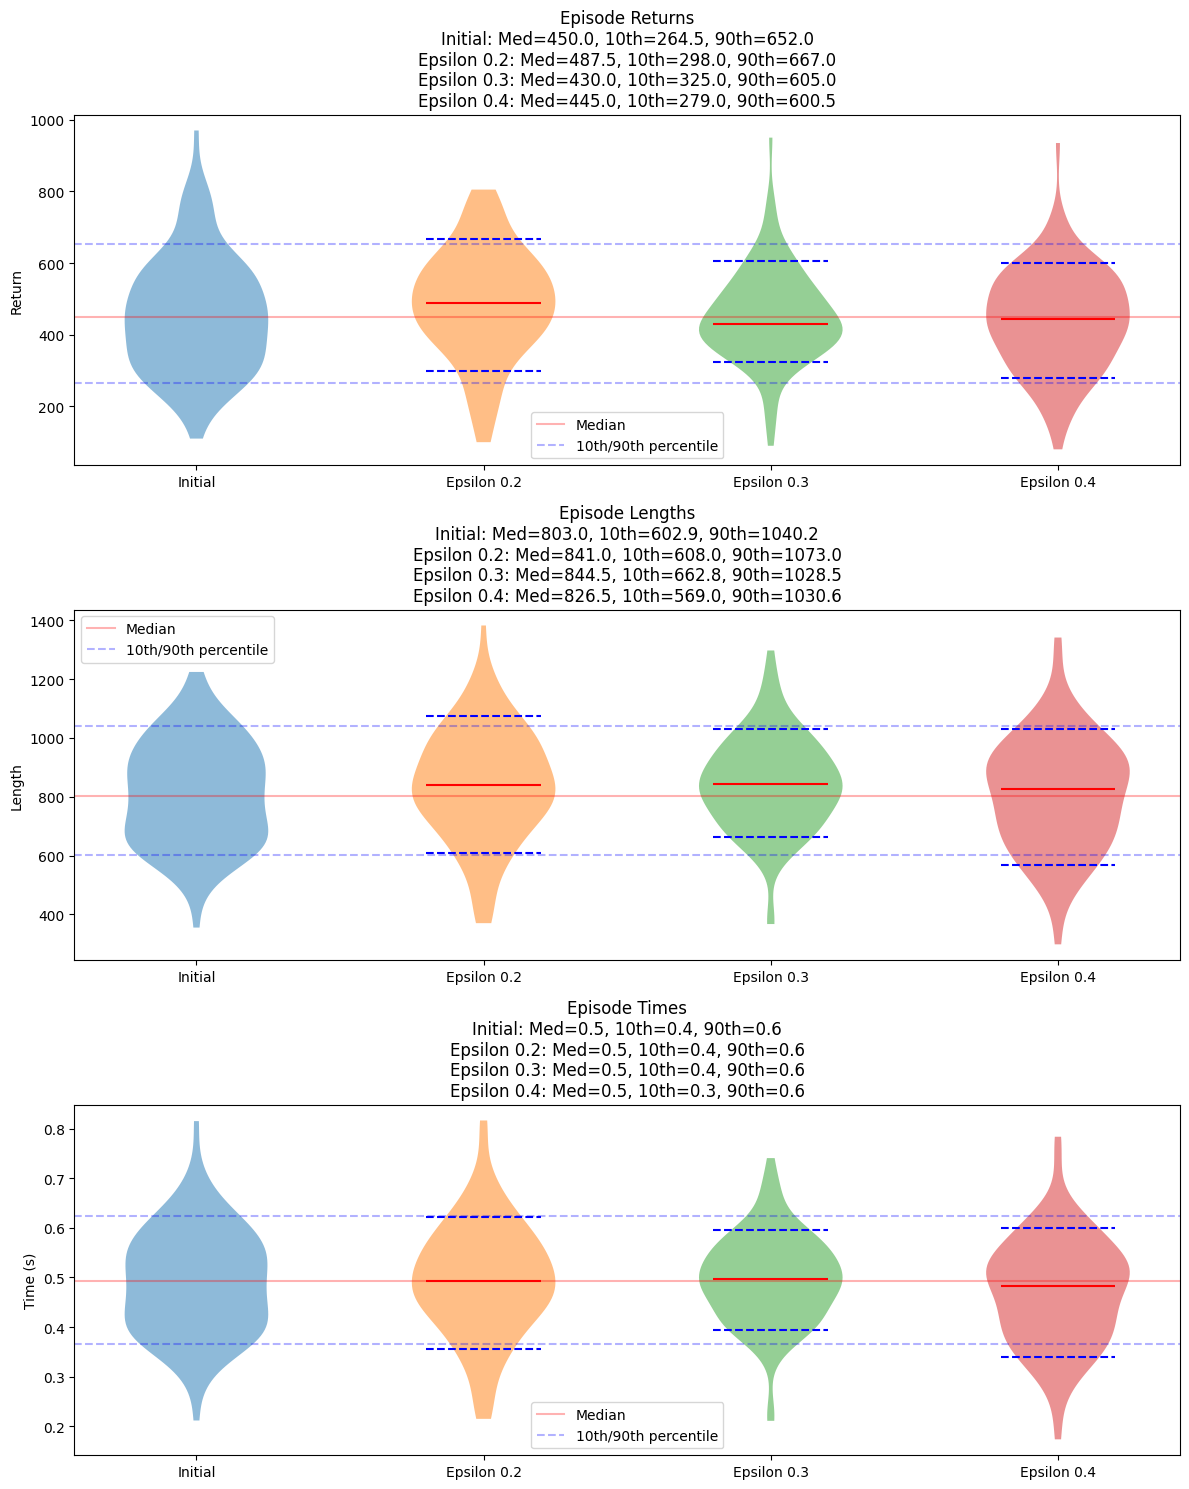

In [111]:
df_initial = load_df(tensorboard_paths['initial_run'], filter_prefix="eval/")
df_epsilon_0_2 = load_df(tensorboard_paths['epsilon_tuning_0.2'], filter_prefix="eval/")
df_epsilon_0_3 = load_df(tensorboard_paths['epsilon_tuning_0.3'], filter_prefix="eval/")
df_epsilon_0_4 = load_df(tensorboard_paths['epsilon_tuning_0.4'], filter_prefix="eval/")

plot_episode_stats_violin(df_initial, df_epsilon_0_2, df_epsilon_0_3, df_epsilon_0_4, labels=['Initial', 'Epsilon 0.2', 'Epsilon 0.3', 'Epsilon 0.4'])

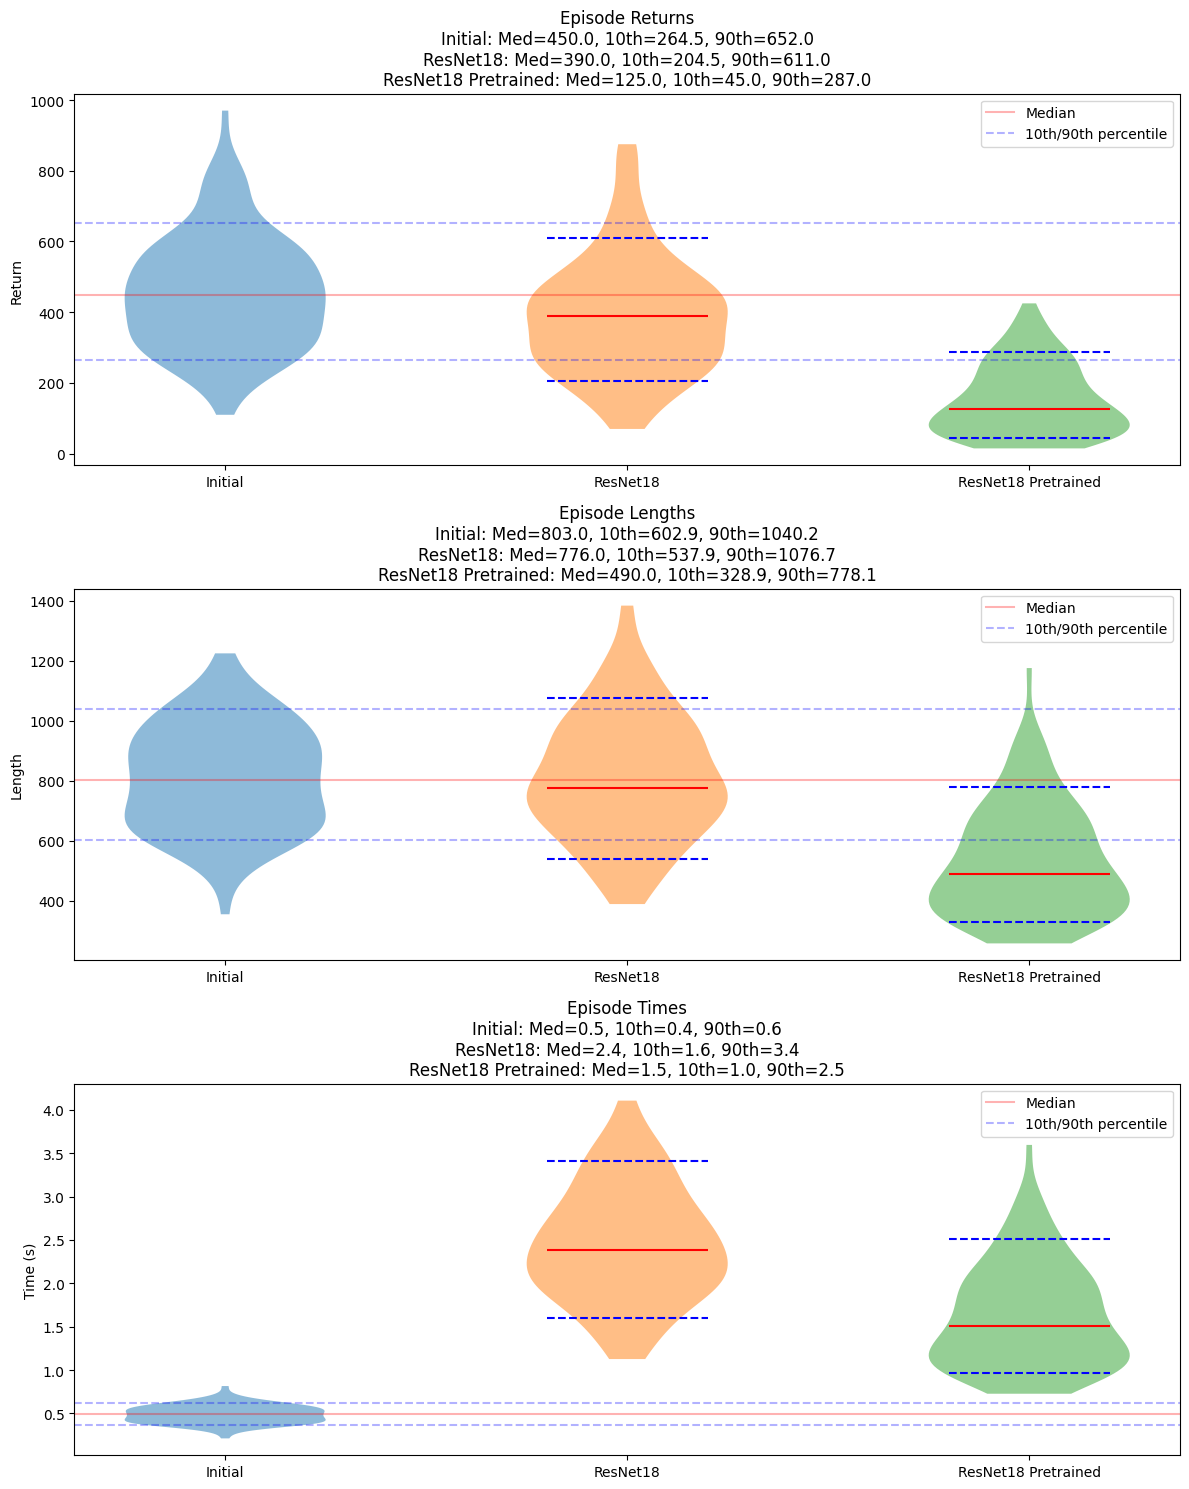

In [112]:
df_resnet = load_df(r"runs\ALE\SpaceInvaders-v5__ppo_resnet__1__20241223_152919\events.out.tfevents.1734964165.DESKTOP-O5Q6R7F.36740.0", filter_prefix="eval/") # eval job on slurm failed
df_resnet_pretrained = load_df(r"runs\ALE\SpaceInvaders-v5__ppo_resnet_pretrained__1__20241223_153307\events.out.tfevents.1734964393.DESKTOP-O5Q6R7F.5756.0", filter_prefix="eval/") # eval job on slurm failed

plot_episode_stats_violin(df_initial, df_resnet, df_resnet_pretrained, labels=['Initial', 'ResNet18', 'ResNet18 Pretrained'])


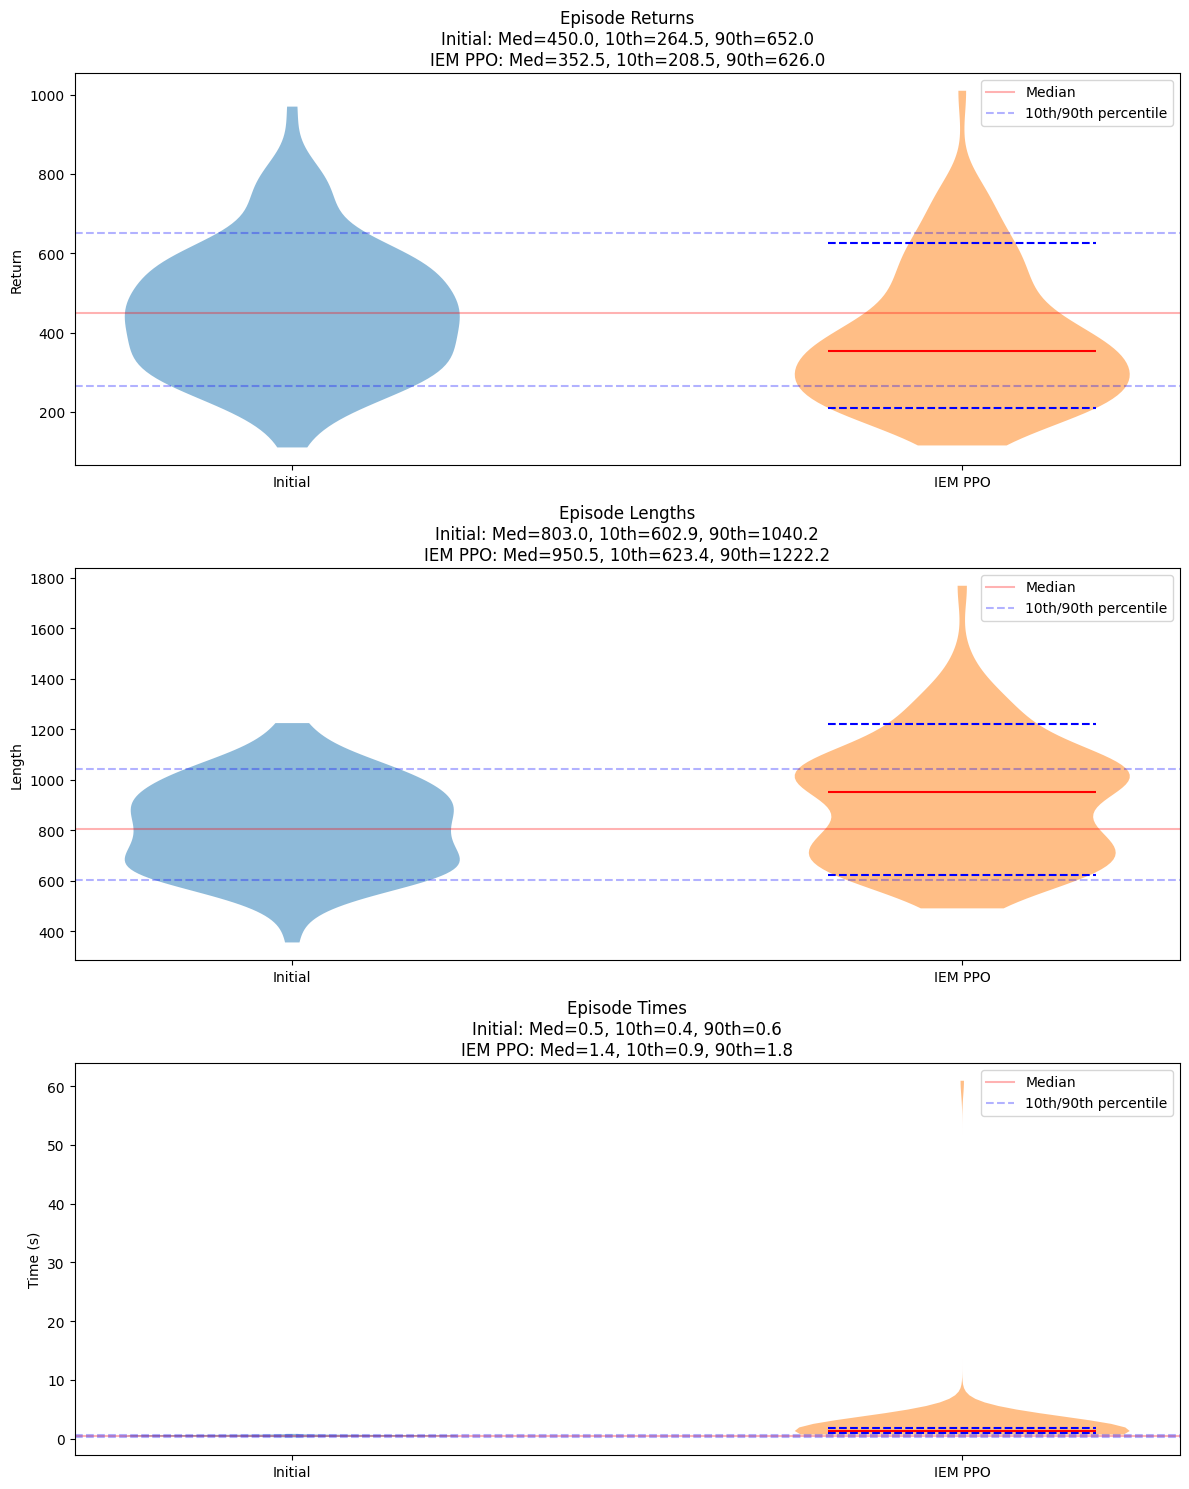

In [113]:
df_iem_ppo = load_df(r"runs\ALE\SpaceInvaders-v5__iem_ppo__1__20241223_125342\events.out.tfevents.1734954828.DESKTOP-O5Q6R7F.36984.0", filter_prefix="eval/")

plot_episode_stats_violin(df_initial, df_iem_ppo, labels=['Initial', 'IEM PPO'])

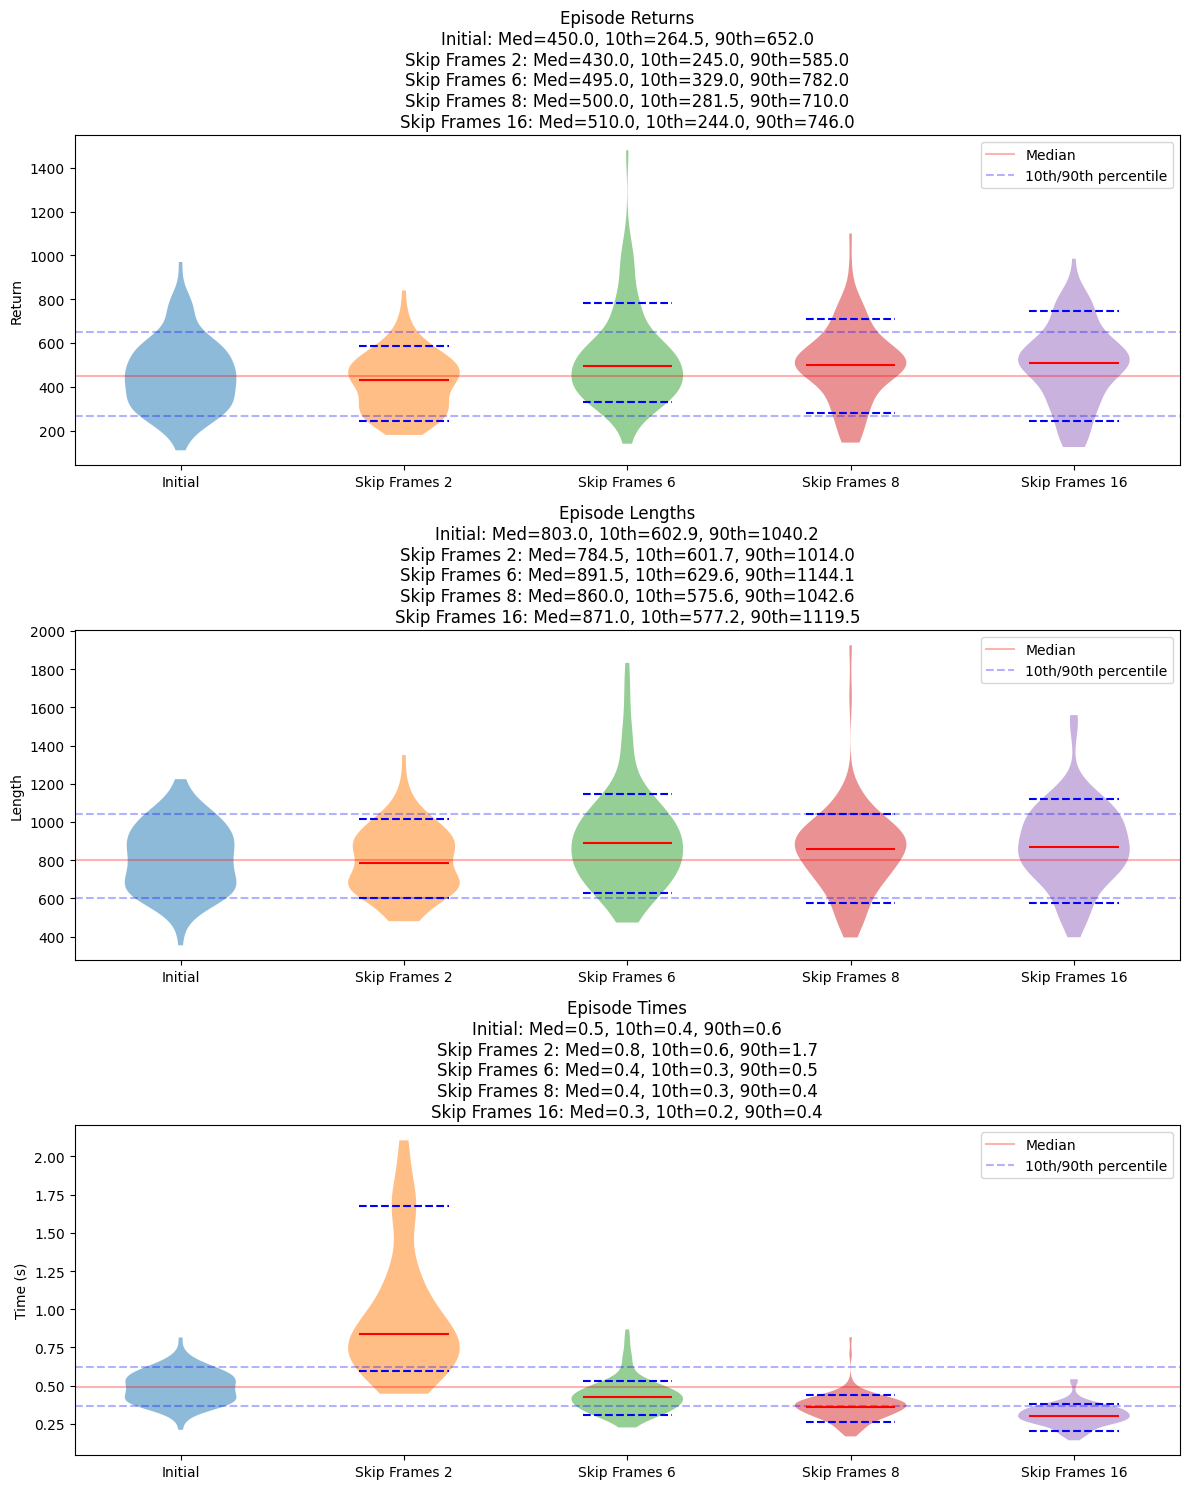

In [115]:
df_skip_frames_2 = load_df(tensorboard_paths['skip_frames_2'], filter_prefix="eval/")
df_skip_frames_6 = load_df(tensorboard_paths['skip_frames_6'], filter_prefix="eval/")
df_skip_frames_8 = load_df(tensorboard_paths['skip_frames_8'], filter_prefix="eval/")
df_skip_frames_16 = load_df(tensorboard_paths['skip_frames_16'], filter_prefix="eval/")
df_skip_frames_32 = load_df(tensorboard_paths['skip_frames_32'], filter_prefix="eval/")

# plot_episode_stats_violin(df_initial, df_skip_frames_2, df_skip_frames_6, df_skip_frames_8, df_skip_frames_16, df_skip_frames_32,
# labels=['Initial', 'Skip Frames 2', 'Skip Frames 6', 'Skip Frames 8', 'Skip Frames 16', 'Skip Frames 32'])
plot_episode_stats_violin(df_initial, df_skip_frames_2, df_skip_frames_6, df_skip_frames_8, df_skip_frames_16,
labels=['Initial', 'Skip Frames 2', 'Skip Frames 6', 'Skip Frames 8', 'Skip Frames 16'])


In [6]:
def print_metric_ranges(df):
    """
    Print the minimum and maximum values for each metric in the dataframe.
    
    Args:
        df: DataFrame containing metrics to analyze
    """
    for col in df.columns:
        print(f"\n{col}:")
        print(f"Min: {df[col].min():.1f}")
        print(f"Max: {df[col].max():.1f}")

print_metric_ranges(initial_df)



eval/episodic_return:
Min: 240.0
Max: 545.0

eval/episodic_length:
Min: 524.0
Max: 1065.0

eval/episodic_time:
Min: 0.7
Max: 1.2


# Train

In [79]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

def load_tensorboard_data(event_path):
    """
    Load training metrics from a TensorBoard event file into a pandas DataFrame
    
    Args:
        event_path (str): Path to the TensorBoard events file
        
    Returns:
        pd.DataFrame: DataFrame containing training metrics with columns:
            - train/episodic_return
            - train/episodic_length 
            - train/episodic_time
    """
    # Load the TensorBoard event file
    event_acc = EventAccumulator(event_path)
    event_acc.Reload()

    # Get list of available tags/metrics
    tags = event_acc.Tags()

    # Create dictionary to store metrics
    metrics = {}

    # Extract metrics into dictionary
    for tag in tags['scalars']:
        events = event_acc.Scalars(tag)
        metrics[tag] = pd.DataFrame(events)[['step', 'value']]
        metrics[tag] = metrics[tag].set_index('step')
        metrics[tag].columns = [tag]

    # Combine all metrics into single dataframe by joining on step index
    df = pd.DataFrame()
    for metric_df in metrics.values():
        df = df.join(metric_df, how='outer')

    # Rename training metrics to have train/ prefix
    rename_map = {
        'charts/episodic_return': 'train/episodic_return',
        'charts/episodic_length': 'train/episodic_length', 
        'charts/episodic_time': 'train/episodic_time'
    }

    df = df.rename(columns=rename_map)

    # Select only training metrics
    cols = ['train/episodic_return', 'train/episodic_length', 'train/episodic_time']
    df = df[cols]
    
    df = df.dropna()

    return df

In [87]:

df_initial_train = load_tensorboard_data(tensorboard_paths['initial_run'])
df_epsilon_0_2_train = load_tensorboard_data(tensorboard_paths['epsilon_tuning_0.2'])
df_epsilon_0_3_train = load_tensorboard_data(tensorboard_paths['epsilon_tuning_0.3'])
df_epsilon_0_4_train = load_tensorboard_data(tensorboard_paths['epsilon_tuning_0.4'])

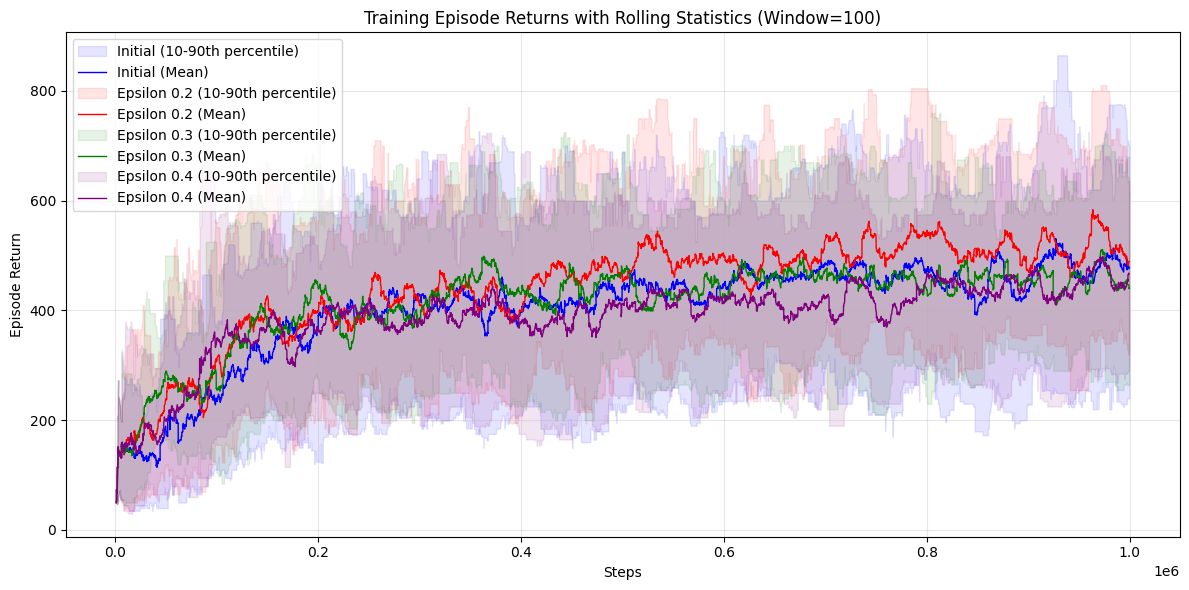

In [88]:
def plot_episode_lengths(dataframes, labels, colors, window=100):
    """
    Plot episode returns with rolling statistics for multiple dataframes
    
    Args:
        dataframes: List of dataframes containing 'train/episodic_return' column
        labels: List of labels for each dataframe
        colors: List of colors for each dataframe
        window: Window size for rolling statistics
    """
    plt.figure(figsize=(12,6))

    for df, label, color in zip(dataframes, labels, colors):
        # Calculate rolling statistics
        rolling_mean = df['train/episodic_return'].rolling(window=window, min_periods=1).mean()
        rolling_10th = df['train/episodic_return'].rolling(window=window, min_periods=1).quantile(0.1)
        rolling_90th = df['train/episodic_return'].rolling(window=window, min_periods=1).quantile(0.9)

        # Plot shaded area between 10th and 90th percentiles
        plt.fill_between(df.index, rolling_10th, rolling_90th, alpha=0.1, color=color, 
                        label=f'{label} (10-90th percentile)')
        
        # Plot mean line
        plt.plot(df.index, rolling_mean, color=color, linestyle='-', 
                label=f'{label} (Mean)', linewidth=1)

    plt.title('Training Episode Returns with Rolling Statistics (Window=100)')
    plt.xlabel('Steps') 
    plt.ylabel('Episode Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_episode_lengths(
    [df_initial_train, df_epsilon_0_2_train, df_epsilon_0_3_train, df_epsilon_0_4_train],
    ['Initial', 'Epsilon 0.2', 'Epsilon 0.3', 'Epsilon 0.4'],
    ['blue', 'red', 'green', 'purple'])

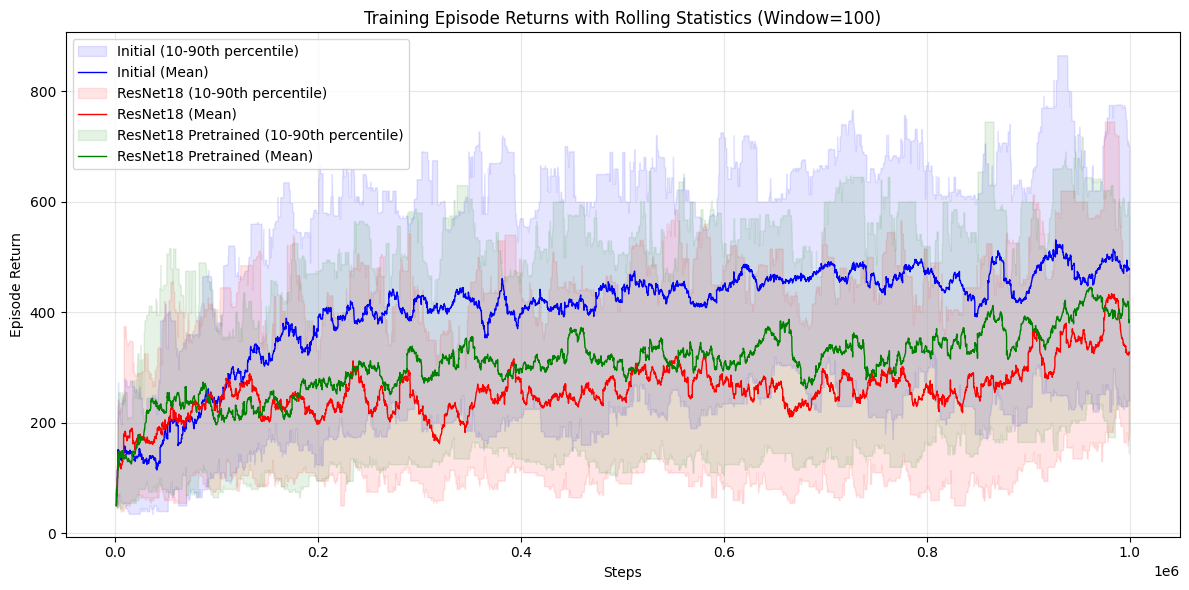

In [93]:
df_resnet_train = load_tensorboard_data(tensorboard_paths['ppo_resnet'])
df_resnet_pretrained_train = load_tensorboard_data(tensorboard_paths['ppo_resnet_pretrained'])

plot_episode_lengths(
    [df_initial_train, df_resnet_train, df_resnet_pretrained_train],
    ['Initial', 'ResNet18', 'ResNet18 Pretrained'],
    ['blue', 'red', 'green'])

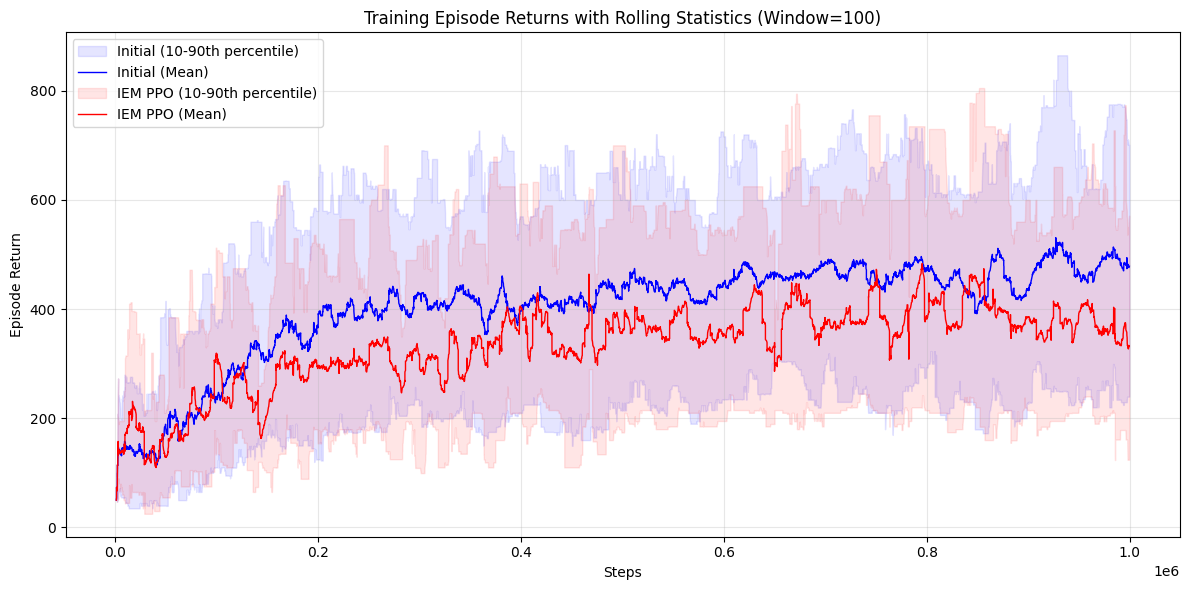

In [96]:
df_iem_ppo_train = load_tensorboard_data(tensorboard_paths['iem_ppo'])

plot_episode_lengths(
    [df_initial_train, df_iem_ppo_train],
    ['Initial', 'IEM PPO'],
    ['blue', 'red'])

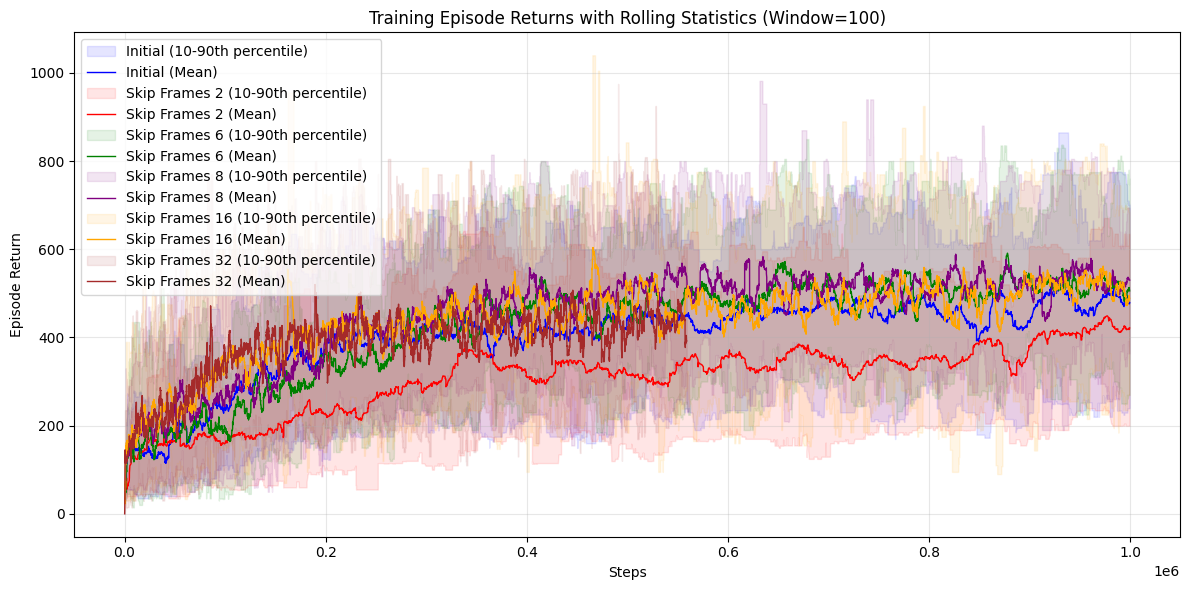

In [98]:
df_skip_frames_2_train = load_tensorboard_data(tensorboard_paths['skip_frames_2'])
df_skip_frames_6_train = load_tensorboard_data(tensorboard_paths['skip_frames_6'])
df_skip_frames_8_train = load_tensorboard_data(tensorboard_paths['skip_frames_8'])
df_skip_frames_16_train = load_tensorboard_data(tensorboard_paths['skip_frames_16'])
df_skip_frames_32_train = load_tensorboard_data(tensorboard_paths['skip_frames_32'])
plot_episode_lengths(
    [df_initial_train, df_skip_frames_2_train, df_skip_frames_6_train, df_skip_frames_8_train, df_skip_frames_16_train, df_skip_frames_32_train],
    ['Initial', 'Skip Frames 2', 'Skip Frames 6', 'Skip Frames 8', 'Skip Frames 16', 'Skip Frames 32'],
    ['blue', 'red', 'green', 'purple', 'orange', 'brown'])
